In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import networkx as nx
from cdlib import algorithms, viz, evaluation
import copy
from datetime import datetime  
from datetime import timedelta  

In [130]:
with open('../pkl/COVID_sorted_W_tensors_ver2.pkl', 'rb') as f:
    travel_tensor_raw = pickle.load(f) 

# with open('../pkl/COVID_weekly_graphs.pkl', 'rb') as f:
#     serial_graphs = pickle.load(f) 

In [131]:
with open('../pkl/new_COVID_order.pkl', 'rb') as f:
    new_order = pickle.load(f) 

In [132]:
country_cutline = 54 # 69, 70 give None homogeneity
travel_tensors = travel_tensor_raw[:,0:country_cutline,0:country_cutline]

In [133]:
with open('../pkl/COVID_label_dict.pkl', 'rb') as f:
    label_dict = pickle.load(f) 

In [134]:
label_dict

{0: 'Jungnang-gu',
 1: 'Dongjak-gu',
 2: 'Yangcheon-gu',
 3: 'Guro-gu',
 4: 'Gangnam-gu',
 5: 'Jung-gu',
 6: 'Jongno-gu',
 7: 'Eunpyeong-gu',
 8: 'Gangseo-gu',
 9: 'Yeongdeungpo-gu',
 10: 'Dongdaemun-gu',
 11: 'Songpa-gu',
 12: 'Seongdong-gu',
 13: 'Geumcheon-gu',
 14: 'Gwanak-gu',
 15: 'Seocho-gu',
 16: 'Seodaemun-gu',
 17: 'Gangbuk-gu',
 18: 'Yongsan-gu',
 19: 'Nowon-gu',
 20: 'Mapo-gu',
 21: 'Ansan-si',
 22: 'Seongbuk-gu',
 23: 'Goyang-si',
 24: 'Seongnam-si',
 25: 'Gwangjin-gu',
 26: 'Dobong-gu',
 27: 'Namyangju-si',
 28: 'Gangdong-gu',
 29: 'Anyang-si',
 30: 'Guri-si',
 31: 'Suwon-si',
 32: 'Paju-si',
 33: 'Gwangmyeong-si',
 34: 'Gimpo-si',
 35: 'Anseong-si',
 36: 'Gunpo-si',
 37: 'Uijeongbu-si',
 38: 'Gwacheon-si',
 39: 'Icheon-si',
 40: 'Pyeongtaek-si',
 41: 'Hanam-si',
 42: 'Siheung-si',
 43: 'Yangpyeong-gun',
 44: 'Dongducheon-si',
 45: 'Yongin-si',
 46: 'Gwangju-si',
 47: 'Bucheon-si',
 48: 'Yeoncheon-gun',
 49: 'Yeoju-si',
 50: 'Hwaseong-si',
 51: 'Uiwang-si',
 52: 'Pocheon-

# Ego tensor

In [135]:
def ego_trans(cnt_num, original_tensors):
    travel_tensors = copy.deepcopy(original_tensors)
    egotensor = []
    for mat in travel_tensors:
        for r in range(mat.shape[0]):
            for c in range(mat.shape[1]):        
                if(r!=cnt_num and c!=cnt_num):
                    mat[r,c]=0
        egotensor.append(mat)
    egotensor = np.array(egotensor)
    return egotensor

In [153]:
node_num = 2

In [154]:
egotensor = ego_trans(node_num, travel_tensors)

In [155]:
egotensor.shape

(22, 54, 54)

#  Egonet visualization

In [156]:
# avg_adj = np.sum(egotensor[:,:,:], 0)
avg_adj = (egotensor[5,:,:])

/Users/gimpuleumoe/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/gimpuleumoe/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


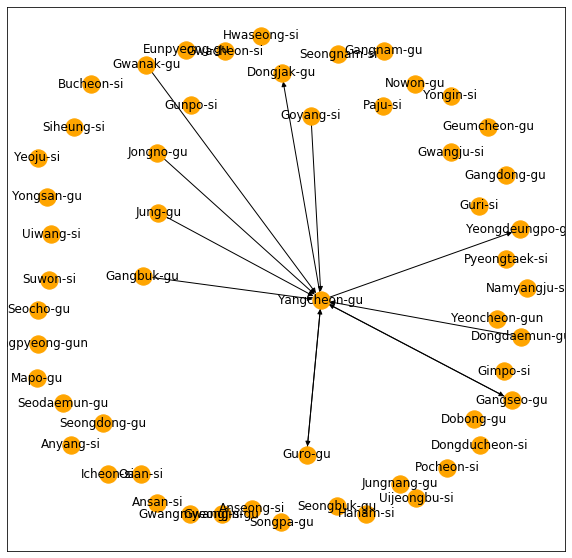

In [157]:
temp_G = nx.from_numpy_matrix(avg_adj, create_using=nx.DiGraph)
G = nx.relabel_nodes(temp_G, label_dict)
pos = nx.spring_layout(G, k = 1)
plt.figure(figsize=(10,10))
nx.draw_networkx(G, pos, node_color='orange')

In [158]:
# coms.communities
# 8, 9, 10, 11, 13, 16, 18, 19, 26, 27, 28
# 2, 3, 5, 12, 20, 23, 24, 25, 29
# 1, 4, 15, 17, 21
# 0, 6, 7, 14, 22

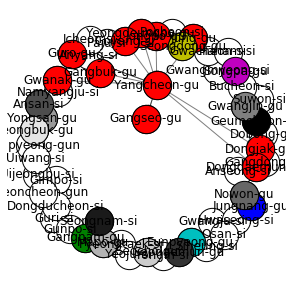

In [159]:
coms = algorithms.leiden(G, weights='weight')
pos = nx.spring_layout(G, k=1)
viz.plot_network_clusters(G, coms, pos, figsize=(5, 5), plot_labels=True, node_size=800)

# Anomaly detection

In [160]:
travel_local = egotensor

In [161]:
npz = np.zeros([country_cutline,country_cutline])
travel_local = np.append([npz], travel_local, axis=0)
travel_local = np.append([npz], travel_local, axis=0)
travel_local = np.append([npz], travel_local, axis=0)
travel_local = np.append([npz], travel_local, axis=0)
travel_local = np.append([npz], travel_local, axis=0)
travel_local =  np.array(travel_local)

In [162]:
travel_local.shape

(27, 54, 54)

In [163]:
out_d_ar = []; out_w_ar = []; in_d_ar = []; in_w_ar = []; neig_ar = []; recep_n_ar = []; tri_ar = []
avg_iw_ar = []; avg_ow_ar = []; max_iw_ar = []; max_ow_ar = []; max_wr_ar = []

In [164]:
Time_interval = len(travel_local)

for mat_t in travel_local[-Time_interval:]:
# adj_mat=travel_tensor[100][:,:226]
    adj_mat = mat_t[:,:travel_local.shape[1]]
    adj_bool = (adj_mat >0).astype(int)
    # print(adj_mat)

    out_degree = np.sum(adj_bool, axis=1) ; out_d_ar.append(out_degree)
    out_weight = np.sum(adj_mat, axis=1) ; out_w_ar.append(out_weight)
    in_degree = np.sum(adj_bool, axis=0) ; in_d_ar.append(in_degree)
    in_weight = np.sum(adj_mat, axis=0) ; in_w_ar.append(in_weight)
    neighbors = np.sum((adj_bool + adj_bool.T)>0, axis=1) ; neig_ar.append(neighbors)
    recp_nb = np.sum((adj_bool + adj_bool.T)==2, axis=1) ; recep_n_ar.append(recp_nb)
    tri = np.diag(np.matmul(adj_bool, adj_bool, adj_bool)) ; tri_ar.append(tri)

    avg_in_w = np.divide(in_weight, in_degree, out = np.zeros_like(in_degree.astype(float)), where= in_degree!=0)
    avg_iw_ar.append(avg_in_w)
    avg_out_w = np.divide(out_weight, out_degree, out = np.zeros_like(out_degree.astype(float)), where= out_degree!=0)
    avg_ow_ar.append(avg_out_w)
    
    max_in_w = np.max(adj_mat, axis=0) ;  max_iw_ar.append(max_in_w)
    max_out_w = np.max(adj_mat, axis=1) ;  max_ow_ar.append(max_out_w)
    max_w_ratio = np.max(np.divide(adj_mat, adj_mat.T, out=np.zeros_like(adj_mat.T), where=adj_mat.T!=0), axis=1)
    max_wr_ar.append(max_w_ratio)

In [165]:
# week_slices = pd.date_range('2020-01-20', periods=22, freq='W')
week_slices = pd.date_range('2020-01-19', periods=23, freq='W')

In [166]:
week_slices

DatetimeIndex(['2020-01-19', '2020-01-26', '2020-02-02', '2020-02-09',
               '2020-02-16', '2020-02-23', '2020-03-01', '2020-03-08',
               '2020-03-15', '2020-03-22', '2020-03-29', '2020-04-05',
               '2020-04-12', '2020-04-19', '2020-04-26', '2020-05-03',
               '2020-05-10', '2020-05-17', '2020-05-24', '2020-05-31',
               '2020-06-07', '2020-06-14', '2020-06-21'],
              dtype='datetime64[ns]', freq='W-SUN')

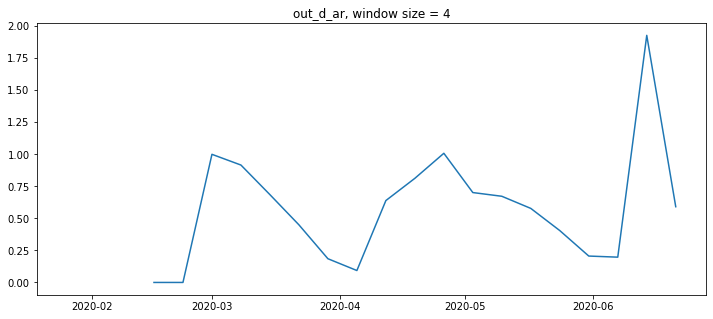

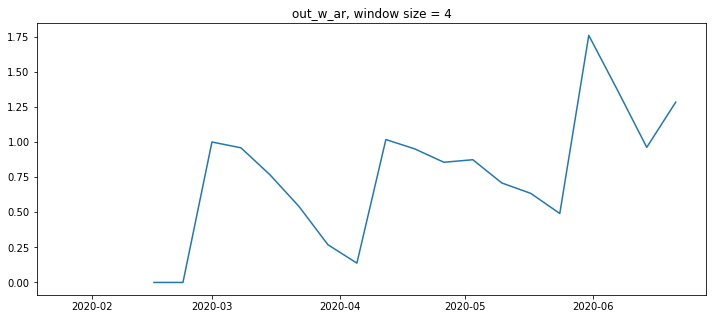

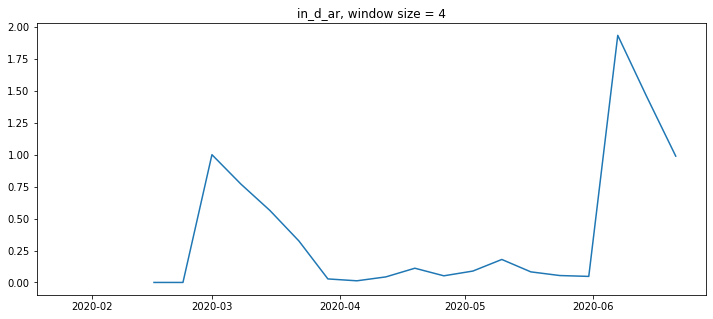

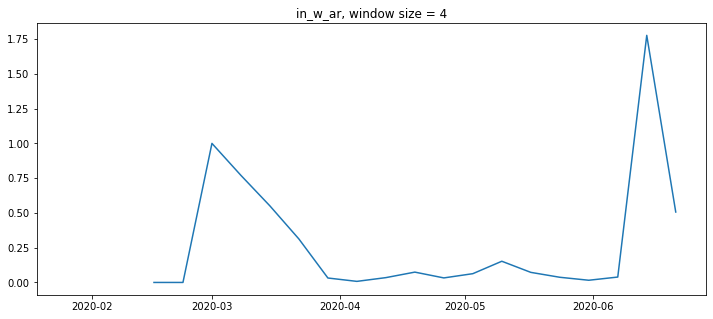

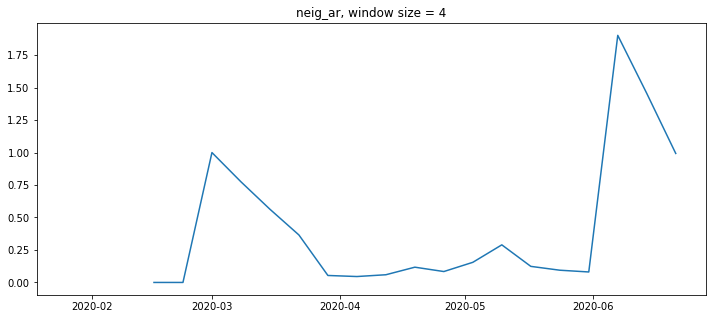

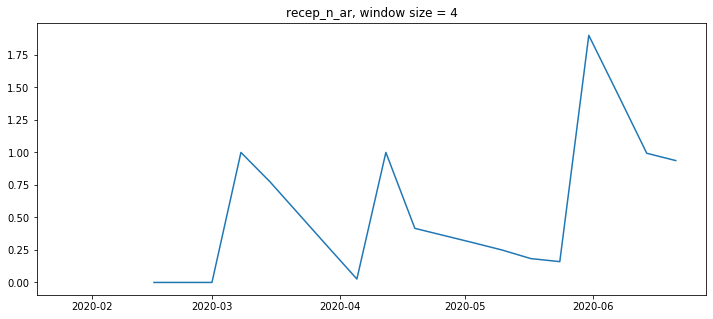

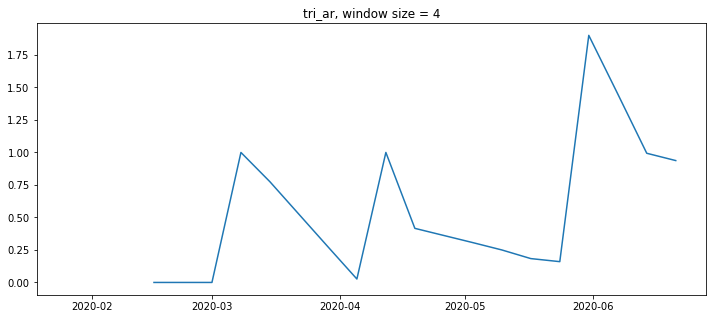

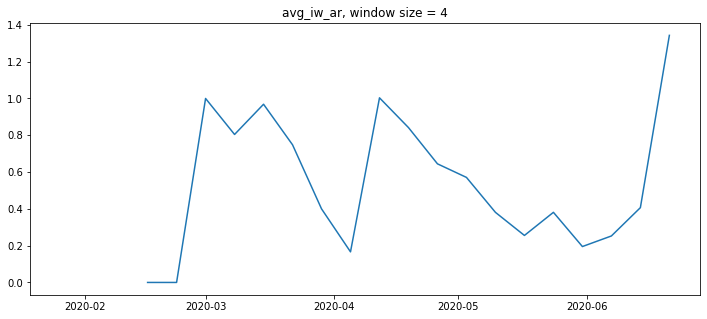

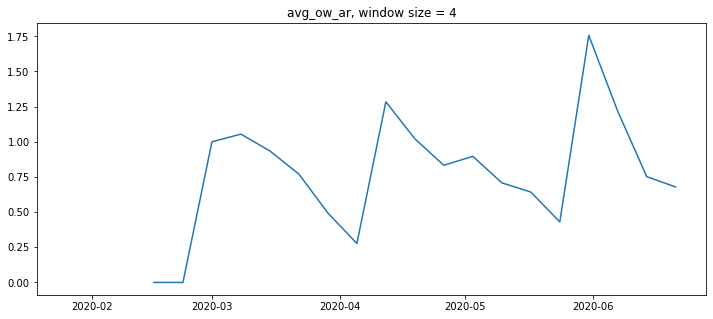

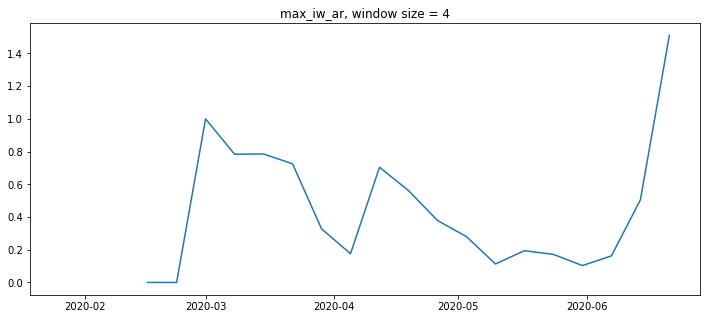

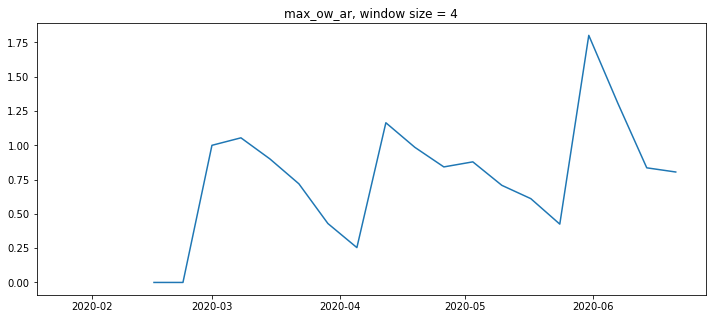

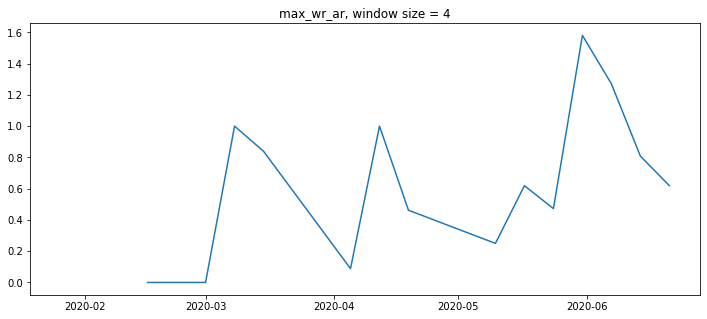

In [167]:
W = 4
feat_arr = [out_d_ar, out_w_ar, in_d_ar, in_w_ar, neig_ar, recep_n_ar, tri_ar, avg_iw_ar, avg_ow_ar, max_iw_ar, max_ow_ar, max_wr_ar]
# feat_arr = [out_w_ar, in_d_ar,neig_ar,avg_ow_ar]
feat_title = ['out_d_ar', 'out_w_ar', 'in_d_ar', 'in_w_ar', 'neig_ar', 'recep_n_ar', 'tri_ar', 'avg_iw_ar', 'avg_ow_ar', 'max_iw_ar', 'max_ow_ar', 'max_wr_ar']
# feat_title = ['out_w_ar', 'in_d_ar','neig_ar','avg_ow_ar']
z_collection = []
iter = 0
#############################################################################
# different pattern from LOF of TBAD
# more stationary. 
# in_d: reasoanble seasonality. star to incrase from July
#############################################################################
for feature in feat_arr:
    feat = feature # out_w_ar, recep_n_ar
    cov_series = []
    for t in range(W, len(feat)):
        C = np.cov(np.array(feat)[t-W:t].T)
        cov_series.append(C)
    u1_list = []
    for i in cov_series:
        U, S, V =np.linalg.svd(i)
        u1_list.append(U[:,0])
    z_list = [0]
    for i in range(0,len(week_slices)-2-(Time_interval-2*W)):
        z_list.append(np.nan)
        
    for i in range(W, len(u1_list)):
        utv = np.dot(u1_list[i], np.mean(np.array(u1_list[i-W:i]), axis=0))
        z = 1-1* utv
        z_list.append(z)
    #############################################################################
#     week_slices = pd.date_range('2016-01-04', periods=200, freq='W')
#     xaxis = week_slices[-Time_interval+2*W:]
    xaxis = week_slices[1:]
    plt.figure(figsize=(12,5))
    plt.plot(xaxis[-len(z_list):], z_list)
#     plt.axvline(x=xaxis[3], color='r', linestyle='--')
#     plt.plot(range(-Time_interval+2*W + 40, -40), z_list[40:-40])
    plt.title(feat_title[iter]+ ", window size = " +str(W))
    iter +=1
    #############################################################################
    z_collection.append(np.array(z_list))

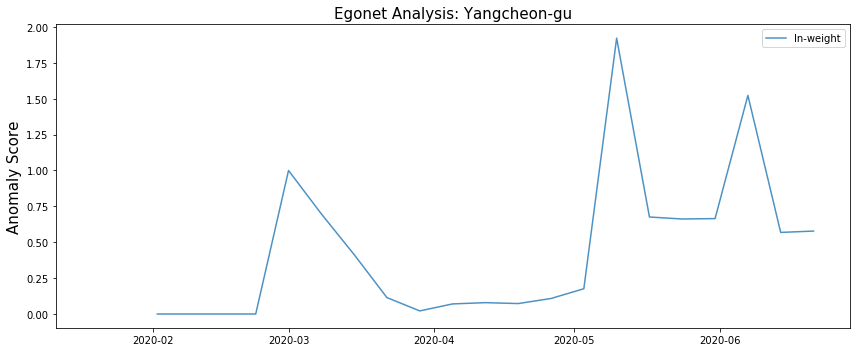

In [168]:
W = 3
feat_arr = [in_w_ar]
feat_title = ['In-weight']
z_collection = []
iter = 0
fig, ax1 = plt.subplots(figsize=(12,5))

plt.title("Egonet Analysis: "+label_dict[node_num], fontsize=15)
for feature in feat_arr:
    feat = feature # out_w_ar, recep_n_ar
    cov_series = []
    for t in range(W, len(feat)):
        C = np.cov(np.array(feat)[t-W:t].T)
        cov_series.append(C)
    u1_list = []
    for i in cov_series:
        U, S, V =np.linalg.svd(i)
        u1_list.append(U[:,0])
    z_list = [0]
    for i in range(0,len(week_slices)-Time_interval+2*W-1):
        z_list.append(np.nan)
        
    for i in range(W, len(u1_list)):
        utv = np.dot(u1_list[i], np.mean(np.array(u1_list[i-W:i]), axis=0))
        z = 1-1* utv
        z_list.append(z)
    xaxis = week_slices
    ax1.plot(xaxis, np.array(z_list)+iter/40, label = feat_title[iter], alpha=0.8)
    iter +=1
    #############################################################################
    z_collection.append(np.array(z_list))
# plt.axvline(x=xaxis[-18], linestyle='-', color='red', label="Massive spread")
# ax1.fill_between([xaxis[-19]+timedelta(days=1.5), xaxis[-18], xaxis[-17]], 0, 1.75, color='magenta', alpha=0.15, label = 'Surge in carriers: 16.Feb ~ 29.Feb')
ax1.set_ylabel("Anomaly Score", fontsize=15)
plt.legend()
fig.tight_layout()
plt.show()

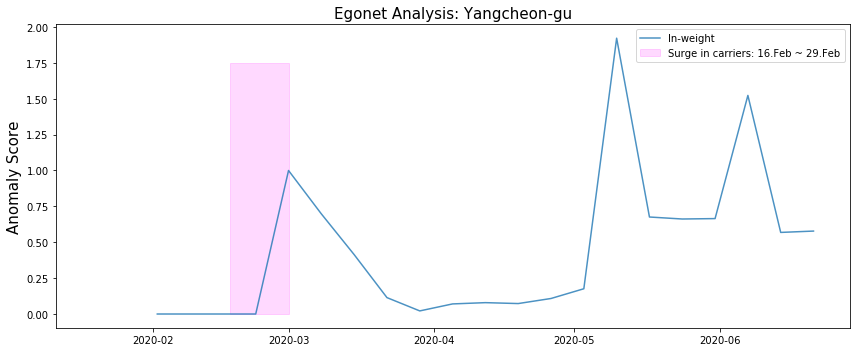

In [169]:
W = 3
feat_arr = [in_w_ar]
feat_title = ['In-weight']
z_collection = []
iter = 0
fig, ax1 = plt.subplots(figsize=(12,5))

plt.title("Egonet Analysis: "+label_dict[node_num], fontsize=15)
for feature in feat_arr:
    feat = feature # out_w_ar, recep_n_ar
    cov_series = []
    for t in range(W, len(feat)):
        C = np.cov(np.array(feat)[t-W:t].T)
        cov_series.append(C)
    u1_list = []
    for i in cov_series:
        U, S, V =np.linalg.svd(i)
        u1_list.append(U[:,0])
    z_list = [0]
    for i in range(0,len(week_slices)-Time_interval+2*W-1):
        z_list.append(np.nan)
        
    for i in range(W, len(u1_list)):
        utv = np.dot(u1_list[i], np.mean(np.array(u1_list[i-W:i]), axis=0))
        z = 1-1* utv
        z_list.append(z)
    xaxis = week_slices
    ax1.plot(xaxis, z_list, label = feat_title[iter], alpha=0.8)
    iter +=1
    #############################################################################
    z_collection.append(np.array(z_list))
# plt.axvline(x=xaxis[-18], linestyle='-', color='red', label="Massive spread")
ax1.fill_between([xaxis[-19]+timedelta(days=1.5), xaxis[-18], xaxis[-17]], 0, 1.75, color='magenta', alpha=0.15, label = 'Surge in carriers: 16.Feb ~ 29.Feb')
ax1.set_ylabel("Anomaly Score", fontsize=15)
plt.legend()
fig.tight_layout()
plt.show()

In [25]:
xaxis

DatetimeIndex(['2020-01-19', '2020-01-26', '2020-02-02', '2020-02-09',
               '2020-02-16', '2020-02-23', '2020-03-01', '2020-03-08',
               '2020-03-15', '2020-03-22', '2020-03-29', '2020-04-05',
               '2020-04-12', '2020-04-19', '2020-04-26', '2020-05-03',
               '2020-05-10', '2020-05-17', '2020-05-24', '2020-05-31',
               '2020-06-07', '2020-06-14', '2020-06-21'],
              dtype='datetime64[ns]', freq='W-SUN')

In [26]:
with open('../pkl/sociogeo_list.pkl', 'rb') as f:
    sociogeo_list = pickle.load(f) 

In [27]:
brokerage_list = sociogeo_list[0]
pop_list = sociogeo_list[1]
entropy_list = sociogeo_list[2]
homo_list = sociogeo_list[3]

In [28]:
xaxis = week_slices[1:]

In [30]:
# # Create some mock data
# t = np.arange(0.01, 10.0, 0.01)
# fig, ax1 = plt.subplots(figsize=(12,5))

# cnt_num = 20

# color = 'tab:red'
# # ax1.set_xlabel('Date')
# ax1.set_ylabel('Entropy, Popularity, Homogeneity', color=color, fontsize=15)
# plt.plot(xaxis, np.array(pop_list)[:,cnt_num], label="popularity", color=color, linestyle='dotted')
# ax1.plot(xaxis, np.array(entropy_list)[:,cnt_num], label="entropy", color=color, linestyle='--')
# ax1.plot(xaxis, np.array(homo_list)[:,cnt_num], label="homogeneity", color=color, )
# ax1.tick_params(axis='y')
# plt.legend(loc=2)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('brokerage', color=color, fontsize=15)  # we already handled the x-label with ax1
# ax2.plot(xaxis, np.array(brokerage_list)[:,cnt_num], label="brokerage")
# ax2.tick_params(axis='y')
# # plt.axvline(x=xaxis[-18], linestyle='-', color='green', label="Massive spread")
# ax2.fill_between([xaxis[-19]+timedelta(days=1), xaxis[-18], xaxis[-17]], 0, 0.05, color='magenta', alpha=0.15, label = 'massive spread: 16.Feb ~ 29.Feb')
# # plt.axvline(x=xaxis[-17], linestyle='--', color=color, label="Rapid increaseof brokerage")
# print(xaxis[5])
# plt.legend(loc=1)
# plt.title('Socio-geological metrics: '+ str(label_dict[cnt_num]), fontsize=15)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

In [31]:
xaxis[-19:-16]
a = xaxis[-19]
a = a+timedelta(days=1)
[a, xaxis[-18], xaxis[-17]]

[Timestamp('2020-02-17 00:00:00', freq='W-SUN'),
 Timestamp('2020-02-23 00:00:00', freq='W-SUN'),
 Timestamp('2020-03-01 00:00:00', freq='W-SUN')]

In [32]:
travel_data = travel_tensor_raw[:,:54,:54]

[ 0.  1.  0.  0. 10. 14. 10.  9.  4.  3.  2.  2.  0.  0.  0.  4.  3.  2.
  2.  9.  0.  0.]


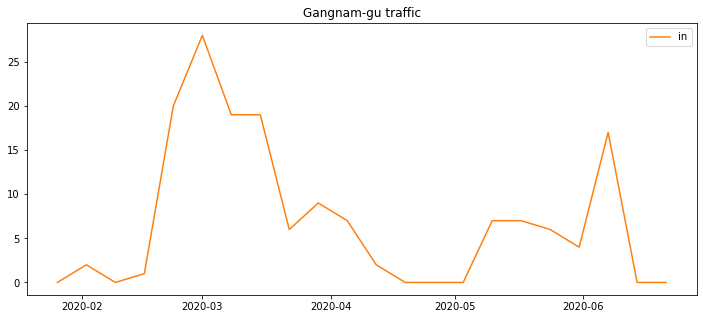

In [34]:
# travel_data.shape
tensors = travel_data[:,:,:54]
tensors.shape

cnt_num = 4
intraffic = np.sum(tensors[:,:,cnt_num], 1) #in-traffic
outtraffic = np.sum(tensors[:,cnt_num,:], 1) #outtraffic
print(intraffic)

plt.figure(figsize=(12,5))
plt.plot(xaxis, intraffic+outtraffic, label= 'in', color='tab:orange')
# plt.plot(xaxis, outtraffic+0.1, label='out', alpha=0.8)
plt.title(str(label_dict[cnt_num])+ " traffic")
# plt.fill_between([xaxis[-17]+timedelta(days=1), xaxis[-16]], 0, 15, color='magenta', alpha=0.15, label = 'massive spread: 01.Mar ~ 07.Mar')
plt.legend()

In [ ]:
xaxis